# Homework 2
#### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard

In [73]:
# Import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [74]:
def bars(title, data, xlab, ylab):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (15,8))
    ax.set_title(title, fontsize=15, fontweight='bold')
    sns.barplot(x=xlab, y=ylab, data=data, saturation=0.7, errcolor='.7')
    plt.xticks(rotation=90)
    plt.show()

## <b> <font color='purple'>Question 1</font> </b>
<b>Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.</b>

We find the unemployment information under Population and social conditions > Labour Market > Employment and unemployment. We chose to work with the Unemployment rates by sex, age and educational attainment level database found in the LFS - detailed annual survey results.

In [75]:
# Load the file
raw_euro = pd.read_csv('lfsa_urgaed_1_Data.csv')

Looking at the data, we see that we have a lot of unecessary informations. Since we just need the total unemployment rate, not considering the level of education nor the gender, we keep only the 'Total' rows from Sex column, and the 'All ISCED 2011 levels' from the ISCED11 column.

In [76]:
# Remove unecessary rows
raw_euro = raw_euro[raw_euro.SEX == 'Total']
raw_euro = raw_euro[raw_euro.ISCED11 == 'All ISCED 2011 levels ']

We now create the Dataframe we will use keeping only the relevant columns GEO and Value. We then convert our values into a float type.

In [77]:
# Create dataframe with only the relevant columns
df_euro = raw_euro[['GEO', 'Value']].copy()
df_euro.columns = ('Country', 'Unemployment (%)')
# Adjust the index
df_euro.set_index((df_euro.index/15).astype(int), inplace=True)
# Convert the values to float
df_euro['Unemployment (%)'] = df_euro['Unemployment (%)'].astype(float)

We now load the json we will use to display our map.

In [78]:
# Load the json data of the map
euro_geo_path = 'topojson/europe.topojson.json'
euro_geo = json.load(open(euro_geo_path))
# First element of the json
euro_geo['objects']['europe']['geometries'][0]

{'arcs': [[[0, 1, 2]], [[3]], [[4]], [[5, 6, 7, 8, 9, 10], [11]]],
 'id': 'AZ',
 'properties': {'NAME': 'Azerbaijan'},
 'type': 'MultiPolygon'}

When we look at the json, we see that we will have to use the country IDs to match the values from our dataframe to the geometries of the json. We thus create a dictionary mapping the country names to their IDs. We also change the name of Germany and Macedonia in our dataframe in order to match them with the json data. We then add a new column in our dataframe containing the IDs for each country.

In [79]:
# Clean the name of Germany and Macedonia
df_euro.Country = df_euro.Country.replace({'Germany (until 1990 former territory of the FRG)': 'Germany'})
df_euro.Country = df_euro.Country.replace({'Former Yugoslav Republic of Macedonia, the': 'The former Yugoslav Republic of Macedonia'})
# Create a dictionary to convert country names to country IDs
dict_country_id = dict(map(lambda x : (x['properties']['NAME'],x['id']),euro_geo['objects']['europe']['geometries']))
# Adding a new column with country IDs
df_euro['Country ID'] = df_euro.Country.map(lambda x : dict_country_id[x])
# Resulting dataframe
df_euro.head()

,Country,Unemployment (%),Country ID
0,Belgium,7.8,BE
1,Bulgaria,7.6,BG
2,Czech Republic,4.0,CZ
3,Denmark,6.2,DK
4,Germany,4.1,DE


To get a better idea of the repartition of the rates, we first display the values in a bar charts.

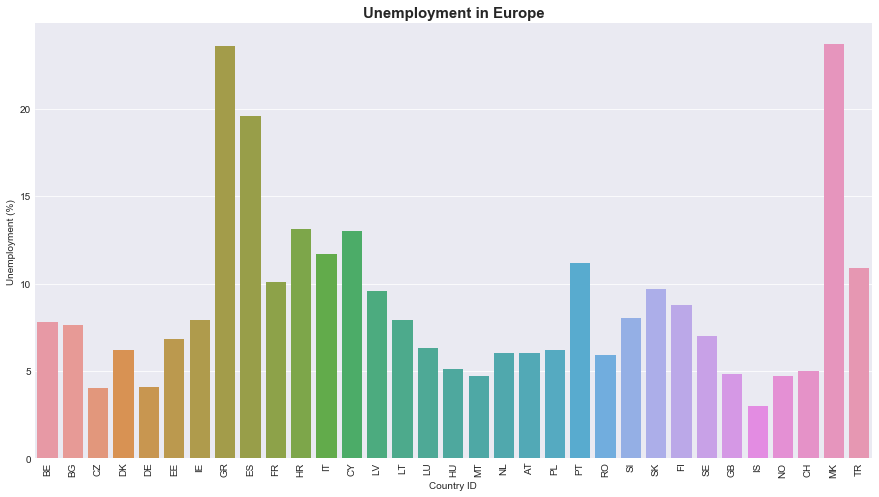

In [80]:
bars("Unemployment in Europe", df_euro, 'Country ID', 'Unemployment (%)')

We now create our map. To define the threshold_scale, we use the mean and the standard deviation of our values. We divide them according to their distance to the mean in terms of the standard deviation.

In [122]:
# Construct the threshold 
mean = df_euro['Unemployment (%)'].mean()
std = df_euro['Unemployment (%)'].std()
min_rate = df_euro['Unemployment (%)'].min()
max_rate = df_euro['Unemployment (%)'].max()

def dist_std(x) :
    return mean + x*std

threshold = [min_rate,dist_std(-1),dist_std(0),dist_std(1),dist_std(2),max_rate]

# Display the visualization map
m_euro = folium.Map([54,15], zoom_start=4)
m_euro.choropleth(
    geo_data = euro_geo,
    data=df_euro,
    columns=['Country ID', 'Unemployment (%)'],
    key_on='feature.id',
    topojson='objects.europe',
    fill_color = 'OrRd', fill_opacity=0.5, line_opacity=0.2,
    legend_name="Unemployment in Europe (in % of population)",
    threshold_scale = threshold
    )
m_euro

The countries with no color are those for which we don't have unemployment informations from Eurostat.

Looking at the map, we observe that three countries stand out : Spain, Macedonia and Greece. They have the highest unemployment rate. Countries with high unemployment rate are mostly mediterranean countries : France, Italy, Turkey. 

If we look at Switzerland, we see that it belongs to countries with a quite low unemployment rate.

## <font color='purple'>Question 2</font> 
<b>Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.
Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.</b>

The unemployement rates of swiss cantons are downloadable through the amstat website (https://www.amstat.ch/v2/index.jsp) according several options we can specify (specific period, geographic level, economic or social attributes, ...). We choose to download the latest data that were available, corresponding to the unemployement rates for September 2017 at a canton level.

In [258]:
amstat_unemp_rate=pd.read_csv('amstat_taux_chomage.csv',sep=',',skiprows=1,skipfooter=1,thousands="'",encoding='utf-16',engine='python')
amstat_unemp_rate.drop(amstat_unemp_rate.columns[[1, 9, 10, 11, 12, 13, 14,15]],axis=1,inplace=True)
amstat_unemp_rate.rename(columns={' ':'Canton'},inplace=True)

In [259]:
amstat_unemp_rate.dtypes

Canton                               object
Taux de chômage                     float64
Coefficients de variation            object
Chômeurs inscrits                     int64
Chômeurs jeunes                       int64
Chômeurs de longue durée              int64
Demandeurs d'emploi                   int64
Demandeurs d'emploi non chômeurs      int64
dtype: object

In [260]:
swiss_cantons=json.load(open('./topojson/ch-cantons.topojson.json'))
# Create a list with the corresponding code (id) for each canton
cantons_id=[(i['properties']['name'],i['id']) for i in swiss_cantons['objects']['cantons']['geometries']]

In [261]:
cantons_id=pd.DataFrame(cantons_id,columns=['Canton','Code'])
cantons_id

,Canton,Code
0,Zürich,ZH
1,Bern/Berne,BE
2,Luzern,LU
3,Uri,UR
4,Schwyz,SZ
5,Obwalden,OW
6,Nidwalden,NW
7,Glarus,GL
8,Zug,ZG
9,Fribourg,FR


We can notice that the swiss cantons names in our dataframe and in the TopoJSON file are really different as the names in the TopoJSON are expressed in the official language for each canton. 
Fortunately, we can see that the cantons are in the same order in both our dataframe and the TopoJSON, we can thus match the canton code according the index.

In [262]:
# Adding a new column with country IDs
amstat_unemp_rate = amstat_unemp_rate.merge(cantons_id[['Code']],left_index=True,right_index=True)
amstat_unemp_rate.head()

,Canton,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Code
0,Zurich,3.3,A,27225,3420,4753,34156,6931,ZH
1,Berne,2.4,A,13658,2003,2336,18385,4727,BE
2,Lucerne,1.7,A,3885,664,453,6756,2871,LU
3,Uri,0.6,C,112,15,13,257,145,UR
4,Schwyz,1.7,A,1455,185,189,2229,774,SZ


In [268]:
swiss_map=folium.Map(location=[46.801111, 8.226667],tiles='cartodbpositron',zoom_start=8)
swiss_map.choropleth(
geo_data=swiss_cantons,
data=amstat_unemp_rate,
columns=['Code', 'Taux de chômage'],
key_on='feature.id',
topojson='objects.cantons',
fill_color='OrRd',
legend_name="Unemployment rates (Nb of registered unemployed/Nb of active persons in %)"
)
swiss_map

## <font color='purple'>Question 3</font> 
<b>Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.</b>

## <font color='purple'>Question 4</font> 
<b>BONUS: using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?</b>